# DAD for Wave by Triplet Loss

## Settings

In [1]:
from pathlib import Path
import sys

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics

import torch
from torchvision import transforms

In [3]:
sys.path.append('../src')

import utils
from dataloader import ESC50DatasetTest
from models import EmbeddingNet, TripletNet

In [4]:
no_cuda = False
seed = 0

In [5]:
data_dir = Path().cwd().parent/'data'
raw_data_dir = data_dir/'external'/'ESC-50'
processed_data_dir = data_dir/'processed'/'ESC-50'
models_dir = Path().cwd().parent/'models'

In [6]:
#model_path = models_dir/'model_tmp.pth'
embeddingnet_path = models_dir/'embeddingnet_best_m08.pth'

In [7]:
metadata_path = raw_data_dir/'meta'/'esc50.csv'
audio_dir = raw_data_dir/'audio'
spectrogram_dir = processed_data_dir/'spectrogram'

In [8]:
train_metadata_path = processed_data_dir/'metadata_train.csv'
valid_metadata_path = processed_data_dir/'metadata_valid.csv'
test_metadata_path = processed_data_dir/'metadata_test.csv'

In [9]:
np.random.seed(seed)

In [10]:
use_cuda = torch.cuda.is_available() and (not no_cuda)
device = 'cuda' if use_cuda else 'cpu'
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = True

print('device: {}'.format(device))

device: cuda


In [11]:
def evaluate_bc(y_true, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    acc = metrics.accuracy_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)

    print('Acc: {:.4f}  Precision: {:.4f}  Recall: {:.4f}  F1: {:4f}'.format(acc, prec, recall, f1))
    print('Confusion Matrix')
    print(confusion_matrix)

In [12]:
def evaluate_auc(labels, scores):
    fpr, tpr, _ = metrics.roc_curve(labels, scores)
    auc = metrics.auc(fpr, tpr)

    plt.title('ROC curve (AUC = {:.2f})'.format(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

## Hyperparameters

In [13]:
input_size = (257, 431)
output_size = 128

batch_size = 8

## Dataloader

In [14]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

In [16]:
dataset = ESC50DatasetTest(
    test_metadata_path, audio_dir, spectrogram_dir, transform,
    )

In [17]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, **kwargs)

## Model

In [18]:
embedding_net = EmbeddingNet(input_size, output_size).to(device)
embedding_net.eval()
embedding_net.load_state_dict(torch.load(str(embeddingnet_path)))

#model = TripletNet(embedding_net).to(device)
#model.eval()
#model.load_state_dict(torch.load(str(model_path)))

## Build Embeddings

In [19]:
embeddings_all = []
for i, (spec, label) in enumerate(dataloader):
    print('\rMinibatch {}/{}'.format(i+1, len(dataloader)), end='')
    if use_cuda: 
        spec =spec.cuda()
    embeddings = embedding_net(spec)
    embeddings = embeddings.cpu().detach().numpy().reshape(-1, output_size)
    embeddings_all.extend(list(embeddings))
print()
dataset.embeddings = np.array(embeddings_all)
dataset.embeddings.shape

Minibatch 25/25


(200, 128)

### Test Settings

In [20]:
label_normal = 1
label_abnormal = -1

In [21]:
dataset.metadata.loc[:, ['target', 'category']].drop_duplicates().reset_index(drop=True)

,target,category
0,2,pig
1,34,can_opening
2,24,coughing
3,40,helicopter
4,28,snoring


In [22]:
_label_normal = 28
indices_normal_all = dataset.label2indices[_label_normal]

In [23]:
n_ref = 15

In [24]:
# all
#indices_abnormal = np.array(list(set(dataset.metadata.index.values) - set(indices_normal_all)))

# one class
_label_abnormal = 40
#indices_abnormal = np.array(list(dataset.label2indices[_label_abnormal]))

# a part of one class
n_abnormal = 40 - n_ref
indices_abnormal = np.random.permutation(dataset.label2indices[_label_abnormal])[:n_abnormal]

indices_abnormal

array([142, 140, 145, 124, 130, 135, 148, 131, 138, 149, 147, 155, 157,
       122, 159, 150, 154, 136, 156, 128, 133, 125, 137, 134, 153])

## Preparation

In [25]:
_indices_ref = np.random.permutation(range(len(indices_normal_all)))[:n_ref]
indices_ref = np.array(indices_normal_all)[_indices_ref]

In [26]:
embeddings_ref = dataset.embeddings[indices_ref]
embeddings_ref.shape

(15, 128)

In [27]:
indices_normal = np.array(sorted(list(set(indices_normal_all) - set(indices_ref))))
embeddings_normal = dataset.embeddings[indices_normal]
embeddings_normal.shape

(25, 128)

In [28]:
embeddings_abnormal = dataset.embeddings[indices_abnormal]
embeddings_abnormal.shape

(25, 128)

In [29]:
labels = [label_normal]*len(embeddings_normal) + [label_abnormal]*len(embeddings_abnormal)
print(labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


## Threshold

### Euclid Distance

In [30]:
threshold = 0.3

In [31]:
data_list = []
for embedding in embeddings_normal:
    euclid_distances = np.sqrt(np.sum((embedding[np.newaxis, :] - embeddings_ref)**2, axis=1))
    data = pd.DataFrame(euclid_distances).describe()
    data_list.append(data.to_dict()[0])
euclid_distance_statistics_normal = pd.io.json.json_normalize(data_list)

In [32]:
print('mean: {:.4f}  max: {:.4f}  min: {:.4f}'.format(
    euclid_distance_statistics_normal['mean'].mean(),
    euclid_distance_statistics_normal['max'].max(),
    euclid_distance_statistics_normal['min'].min(),
    ))

mean: 0.5671  max: 1.2979  min: 0.0527


In [33]:
euclid_distance_statistics_normal

,25%,50%,75%,count,max,mean,min,std
0,0.201340,0.513977,0.876741,15.0,1.161479,0.555606,0.134268,0.378833
1,0.288342,0.715621,0.914429,15.0,1.194572,0.661224,0.107552,0.389264
2,0.185096,0.412587,0.784638,15.0,1.095555,0.494645,0.116056,0.356001
3,0.229812,0.396896,0.590661,15.0,0.944771,0.443971,0.087420,0.272064
4,0.522689,0.636502,0.719550,15.0,0.962553,0.641067,0.376451,0.161673
5,0.329251,0.459512,0.635534,15.0,0.925438,0.514616,0.177690,0.243116
6,0.343036,0.661624,1.013195,15.0,1.272601,0.663942,0.131596,0.404980
7,0.343515,0.660840,1.012378,15.0,1.273263,0.661402,0.118200,0.407671
8,0.318893,0.622712,0.990928,15.0,1.267396,0.639364,0.120746,0.411175
9,0.297220,0.581031,0.959556,15.0,1.252412,0.603667,0.078354,0.420469


In [34]:
data_list = []
for embedding in embeddings_abnormal:
    euclid_distances = np.sqrt(np.sum((embedding[np.newaxis, :] - embeddings_ref)**2, axis=1))
    data = pd.DataFrame(euclid_distances).describe()
    data_list.append(data.to_dict()[0])
euclid_distance_statistics_abnormal = pd.io.json.json_normalize(data_list)

In [35]:
print('mean: {:.4f}  max: {:.4f}  min: {:.4f}'.format(
    euclid_distance_statistics_abnormal['mean'].mean(),
    euclid_distance_statistics_abnormal['max'].max(),
    euclid_distance_statistics_abnormal['min'].min(),
    ))

mean: 0.7377  max: 1.3620  min: 0.0884


In [36]:
euclid_distance_statistics_abnormal

,25%,50%,75%,count,max,mean,min,std
0,0.527957,0.924430,1.075747,15.0,1.318584,0.822144,0.136851,0.397879
1,0.438232,0.499948,0.599153,15.0,0.774007,0.526865,0.331705,0.129153
2,0.297232,0.585064,0.904649,15.0,1.147205,0.615950,0.248825,0.337684
3,0.603021,0.985279,1.124602,15.0,1.352607,0.880113,0.212024,0.382795
4,0.608757,0.987612,1.126740,15.0,1.353791,0.884371,0.222367,0.379810
5,0.541536,0.932658,1.081078,15.0,1.321212,0.830929,0.152956,0.393018
6,0.386337,0.510385,0.786583,15.0,1.021433,0.570936,0.183405,0.273343
7,0.626315,1.000717,1.136562,15.0,1.359597,0.897432,0.243486,0.374599
8,0.342438,0.648909,0.808443,15.0,1.086838,0.635756,0.253908,0.295960
9,0.392179,0.499515,0.760304,15.0,0.991561,0.560472,0.176704,0.259887


#### Score and Predict

In [37]:
column_name = 'mean'
scores = (
    list(euclid_distance_statistics_normal[column_name].values)
    + list(euclid_distance_statistics_abnormal[column_name].values)
    )

In [38]:
preds = [
    label_normal
    if (score < threshold)
    else label_abnormal
    for score in scores
    ]

In [39]:
scores = [-score for score in scores]

#### Evaluate

In [40]:
print('#Pred Normal: {}'.format(preds.count(1)))

#Pred Normal: 0


In [41]:
evaluate_bc(labels, preds)

Acc: 0.5000  Precision: 0.0000  Recall: 0.0000  F1: 0.000000
Confusion Matrix
[[25  0]
 [25  0]]


/home/morita/.conda/envs/morita/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/morita/.conda/envs/morita/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


AUC: 0.8352


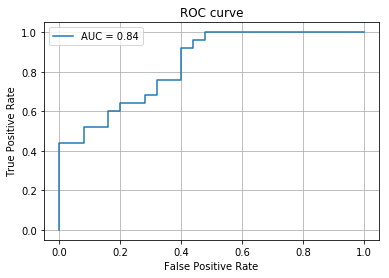

In [42]:
# AUROC

fpr, tpr, _ = metrics.roc_curve(labels, scores)
auc = metrics.auc(fpr, tpr)
print('AUC: {:.4f}'.format(auc))

plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

### Cosine Similarity

#### Watch Data

In [43]:
threshold = 0.7

In [44]:
data_list = []
for embedding in embeddings_normal:
    cosine_similarities = embeddings_ref.dot(embedding)
    data = pd.DataFrame(cosine_similarities).describe()
    data_list.append(data.to_dict()[0])
cosine_similarity_statistics_normal = pd.io.json.json_normalize(data_list)

In [45]:
print('mean: {:.4f}  max: {:.4f}  min: {:.4f}'.format(
    cosine_similarity_statistics_normal['mean'].mean(),
    cosine_similarity_statistics_normal['max'].max(),
    cosine_similarity_statistics_normal['min'].min(),
    ))

mean: 0.7781  max: 0.9986  min: 0.1577


In [46]:
cosine_similarity_statistics_normal

,25%,50%,75%,count,max,mean,min,std
0,0.612694,0.867914,0.979728,15.0,0.990986,0.778678,0.325484,0.243470
1,0.581696,0.743943,0.953366,15.0,0.994216,0.710679,0.286498,0.249577
2,0.688613,0.914886,0.982841,15.0,0.993266,0.818519,0.399880,0.214541
3,0.822202,0.921237,0.973407,15.0,0.996179,0.866903,0.553704,0.145612
4,0.741062,0.797432,0.863163,15.0,0.929142,0.782318,0.536745,0.110997
5,0.797952,0.894424,0.944739,15.0,0.984213,0.840002,0.571782,0.134904
6,0.484033,0.781126,0.941072,15.0,0.991341,0.703053,0.190243,0.291353
7,0.484822,0.781645,0.940898,15.0,0.993014,0.703716,0.189400,0.291748
8,0.506097,0.806115,0.949023,15.0,0.992710,0.716710,0.196854,0.289343
9,0.536348,0.831201,0.955485,15.0,0.996930,0.735289,0.215732,0.283117


In [47]:
data_list = []
for embedding in embeddings_abnormal:
    cosine_similarities = embeddings_ref.dot(embedding)
    data = pd.DataFrame(cosine_similarities).describe()
    data_list.append(data.to_dict()[0])
cosine_similarity_statistics_abnormal = pd.io.json.json_normalize(data_list)

In [48]:
print('mean: {:.4f}  max: {:.4f}  min: {:.4f}'.format(
    cosine_similarity_statistics_abnormal['mean'].mean(),
    cosine_similarity_statistics_abnormal['max'].max(),
    cosine_similarity_statistics_abnormal['min'].min(),
    ))

mean: 0.6633  max: 0.9961  min: 0.0724


In [49]:
cosine_similarity_statistics_abnormal

,25%,50%,75%,count,max,mean,min,std
0,0.421301,0.572715,0.856246,15.0,0.990636,0.588163,0.130668,0.297188
1,0.820393,0.875026,0.903976,15.0,0.944986,0.853423,0.700457,0.073257
2,0.588587,0.828850,0.955826,15.0,0.969043,0.757089,0.341961,0.231928
3,0.367600,0.514613,0.814025,15.0,0.977523,0.544319,0.085227,0.306598
4,0.365196,0.512312,0.810574,15.0,0.975276,0.541625,0.083625,0.306175
5,0.415570,0.565075,0.849048,15.0,0.988302,0.582696,0.127199,0.296976
6,0.688830,0.869754,0.925146,15.0,0.983181,0.802148,0.478338,0.173298
7,0.354089,0.499282,0.799839,15.0,0.970357,0.531823,0.075748,0.306862
8,0.673112,0.789459,0.940058,15.0,0.967765,0.757031,0.409392,0.193781
9,0.709229,0.875242,0.923018,15.0,0.984388,0.811416,0.508403,0.160755


#### Predict and Score

In [50]:
column_name = 'mean'
scores = (
    list(cosine_similarity_statistics_normal[column_name].values)
    + list(cosine_similarity_statistics_abnormal[column_name].values)
    )

In [51]:
preds = [
    label_normal
    if (score > threshold)
    else label_abnormal
    for score in scores
    ]

#### Evaluate

In [52]:
print('#Pred Normal: {}'.format(preds.count(1)))

#Pred Normal: 32


In [53]:
evaluate_bc(labels, preds)

Acc: 0.7400  Precision: 0.6875  Recall: 0.8800  F1: 0.771930
Confusion Matrix
[[15 10]
 [ 3 22]]


AUC: 0.7936


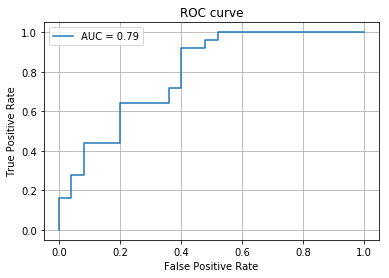

In [54]:
# AUROC

fpr, tpr, _ = metrics.roc_curve(labels, scores)
auc = metrics.auc(fpr, tpr)
print('AUC: {:.4f}'.format(auc))

plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

## Test by LOF

#### Train

In [55]:
clf = LocalOutlierFactor(
    n_neighbors=2,
    novelty=True,
    contamination='auto',
    )

In [56]:
clf.fit(embeddings_ref)

LocalOutlierFactor(algorithm='auto', contamination='auto', leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=None,
          n_neighbors=2, novelty=True, p=2)

#### Score and Predict

In [57]:
embeddings = list(embeddings_normal) + list(embeddings_abnormal)
preds = clf.predict(embeddings)
scores = clf.score_samples(embeddings)

In [58]:
print('#Pred Normal: {}'.format(list(preds).count(1)))

#Pred Normal: 44


#### Evaluate

In [59]:
evaluate_bc(labels, preds)

Acc: 0.5800  Precision: 0.5455  Recall: 0.9600  F1: 0.695652
Confusion Matrix
[[ 5 20]
 [ 1 24]]


AUC: 0.6288


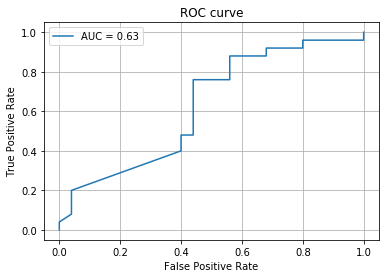

In [60]:
# AUROC

fpr, tpr, _ = metrics.roc_curve(labels, scores)
auc = metrics.auc(fpr, tpr)
print('AUC: {:.4f}'.format(auc))

plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()